<a href="https://colab.research.google.com/github/rafatb/Berlin_Airbnb_Price_Prediction/blob/main/5_Airbnb_Berlin_Model_and_Hyperparameter_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regressor Models and Hyperparameter Finetuning**

In [273]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [274]:
!pip install -U scikit-learn

In [275]:
import matplotlib.pyplot as plt
#%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.datasets import make_classification
#from xgboost import XGBClassifier
#!pip install xgboost scikit-learn pandas numpy
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

#Get the data

In [276]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/berline/after_feature_selection.csv')

In [277]:
df.head(5)

,Unnamed: 0,Checkin Rating,Communication Rating,Location Rating,Value Rating,Reviews,Bedrooms,Beds,Bathrooms,Guests Included,Instant Bookable,Is Exact Location,Postal Code,Property Type,Neighborhood Group,Room Type,Distance From Center,Host Since Year Old,Price
0,0,10.0,10.0,9.0,10.0,7.0,1.0,1.0,1.0,1.0,False,True,24,1,6,1,5.1,17,17.0
1,1,9.0,9.0,10.0,9.0,144.0,1.0,2.0,1.0,2.0,False,True,18,1,6,0,3.7,17,90.0
2,2,10.0,10.0,10.0,10.0,229.0,1.0,2.0,1.0,1.0,False,True,24,1,6,1,4.6,16,33.0
3,3,10.0,10.0,10.0,10.0,6.0,4.0,7.0,0.0,5.0,False,False,18,1,6,0,3.5,16,180.0
4,4,9.0,10.0,9.0,9.0,23.0,0.0,1.0,1.0,1.0,False,True,24,1,6,0,5.0,16,70.0


In [278]:
#stubborn upload bug is here to stay
del df['Unnamed: 0']
#del df_ros['split']

#fixing the Price outlier manually  

In [279]:
df= df[(df['Price']<600) & (df['Price']>0)]

In [280]:
df.shape

(23457, 18)

#Metrics init

In [281]:
models_list = pd.DataFrame()

In [282]:
def regressionMetrics(y, yhat):
    res = {'MSE': metrics.mean_squared_error(y,yhat),
           'RMSE': np.sqrt(metrics.mean_squared_error(y,yhat)),
           'MAE': metrics.mean_absolute_error(y,yhat),

          }
    # Calculate RMSLE using absolute values to avoid negative issues
    res['RMSLE'] = np.sqrt(metrics.mean_squared_log_error(np.abs(y), np.abs(yhat)))

    return res

In [283]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Checkin Rating,23457.0,9.717121,0.707339,2.0,10.0,10.0,10.0,10.0
Communication Rating,23457.0,9.736710,0.692975,2.0,10.0,10.0,10.0,10.0
Location Rating,23457.0,9.533529,0.763252,2.0,9.0,10.0,10.0,10.0
Value Rating,23457.0,9.392292,0.875563,2.0,9.0,10.0,10.0,10.0
Reviews,23457.0,19.286354,40.412387,0.0,1.0,5.0,17.0,545.0
Bedrooms,23457.0,1.159910,0.654201,0.0,1.0,1.0,1.0,10.0
Beds,23457.0,1.639617,1.219045,0.0,1.0,1.0,2.0,22.0
Bathrooms,23457.0,0.880952,0.323802,0.0,1.0,1.0,1.0,1.0
Guests Included,23457.0,1.344503,0.849953,1.0,1.0,1.0,1.0,16.0
Postal Code,23457.0,60.084410,53.650303,0.0,18.0,56.0,73.0,206.0


Display correlation and heat map

<Axes: >

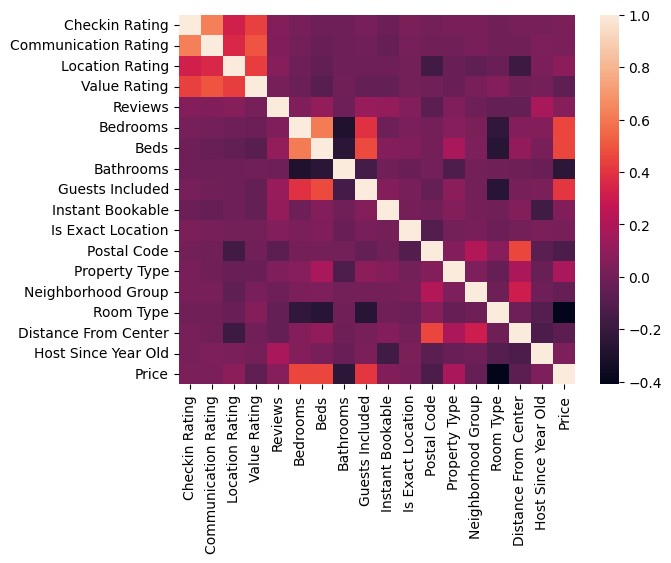

In [284]:
sns.heatmap(df.corr())

Display the correlation

In [285]:
df.corr()

,Checkin Rating,Communication Rating,Location Rating,Value Rating,Reviews,Bedrooms,Beds,Bathrooms,Guests Included,Instant Bookable,Is Exact Location,Postal Code,Property Type,Neighborhood Group,Room Type,Distance From Center,Host Since Year Old,Price
Checkin Rating,1.000000,0.621418,0.322109,0.439141,0.059558,0.018526,-0.010300,-0.010785,0.014711,-0.024045,0.032312,0.005832,0.020386,0.019776,-0.003355,0.015949,0.017573,0.033600
Communication Rating,0.621418,1.000000,0.358657,0.496990,0.048002,0.004759,-0.033723,-0.009545,0.000988,-0.038940,0.015573,-0.004881,-0.004510,0.020062,-0.007940,-0.004832,0.035951,0.026976
Location Rating,0.322109,0.358657,1.000000,0.430506,0.065851,-0.012958,-0.055125,-0.013821,-0.012845,-0.013382,0.005824,-0.167440,-0.034901,-0.061124,-0.025757,-0.183156,0.025726,0.080129
Value Rating,0.439141,0.496990,0.430506,1.000000,0.018724,-0.022998,-0.084859,-0.002184,-0.046238,-0.045007,0.007092,0.000990,-0.025416,0.024390,0.062949,0.001227,0.012005,-0.061225
Reviews,0.059558,0.048002,0.065851,0.018724,1.000000,0.041279,0.107800,-0.010463,0.128991,0.114498,0.057245,-0.077110,0.043491,-0.008707,-0.044246,-0.046516,0.178478,0.065591
Bedrooms,0.018526,0.004759,-0.012958,-0.022998,0.041279,1.000000,0.609948,-0.295137,0.391588,-0.013996,0.024524,0.011844,0.063768,0.035382,-0.226354,0.058635,0.057827,0.458215
Beds,-0.010300,-0.033723,-0.055125,-0.084859,0.107800,0.609948,1.000000,-0.249641,0.465808,0.060005,0.041922,0.011293,0.178212,0.037160,-0.260429,0.105490,0.023426,0.455373
Bathrooms,-0.010785,-0.009545,-0.013821,-0.002184,-0.010463,-0.295137,-0.249641,1.000000,-0.156685,-0.003098,-0.027331,0.003231,-0.120259,0.002946,-0.008295,-0.014980,-0.027894,-0.242720
Guests Included,0.014711,0.000988,-0.012845,-0.046238,0.128991,0.391588,0.465808,-0.156685,1.000000,0.057891,0.020288,-0.042476,0.084437,0.003392,-0.259755,0.018223,0.035286,0.404798
Instant Bookable,-0.024045,-0.038940,-0.013382,-0.045007,0.114498,-0.013996,0.060005,-0.003098,0.057891,1.000000,0.010012,0.001369,0.058352,0.008729,-0.004310,0.059229,-0.173135,0.050533


#price destripution

<Axes: xlabel='Price', ylabel='Density'>

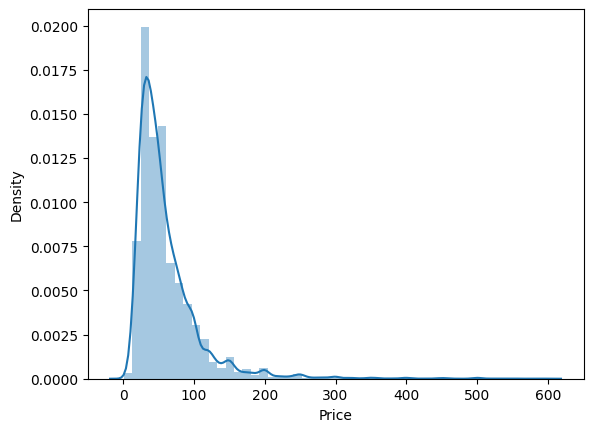

In [286]:
sns.distplot(df.Price)

In [287]:
df['Price'].max()

599.0

In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23457 entries, 0 to 23535
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Checkin Rating        23457 non-null  float64
 1   Communication Rating  23457 non-null  float64
 2   Location Rating       23457 non-null  float64
 3   Value Rating          23457 non-null  float64
 4   Reviews               23457 non-null  float64
 5   Bedrooms              23457 non-null  float64
 6   Beds                  23457 non-null  float64
 7   Bathrooms             23457 non-null  float64
 8   Guests Included       23457 non-null  float64
 9   Instant Bookable      23457 non-null  bool   
 10  Is Exact Location     23457 non-null  bool   
 11  Postal Code           23457 non-null  int64  
 12  Property Type         23457 non-null  int64  
 13  Neighborhood Group    23457 non-null  int64  
 14  Room Type             23457 non-null  int64  
 15  Distance From Center  23

#Create and Train Regression Models

In [289]:
from sklearn.model_selection import train_test_split

y = df.Price
X = df.drop(columns=['Price'])

# Split into train+val and test sets (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split train+val into train and val sets (75% train, 25% val from the train+val set)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

#Regression Models

In [290]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
#!pip install xgboost
import xgboost as xgb

##Linear Regression

In [291]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)  # Use X_train and y_train

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

In [292]:
regressionMetrics(y_val, y_val_pred)

{'MSE': 1459.1847820258704,
 'RMSE': np.float64(38.19927724481015),
 'MAE': 22.460419633248115,
 'RMSLE': np.float64(0.48639676296885254)}

In [293]:
model_dict = {'model': "Linear Regression"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val, y_val_pred)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,1459.184782,38.199277,22.46042,0.486397


<Axes: xlabel='Price'>

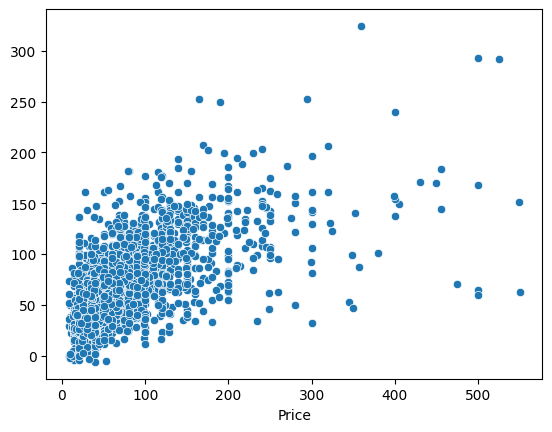

In [294]:
sns.scatterplot(x=y_val, y=y_val_pred)

##Decision Tree

In [295]:
mod2 = DecisionTreeRegressor(random_state=1)
mod2.fit(X_train, y_train)
# Make predictions on the validation set
y_val_pred2 = mod2.predict(X_val)

In [296]:
regressionMetrics(y_val, y_val_pred)

{'MSE': 1459.1847820258704,
 'RMSE': np.float64(38.19927724481015),
 'MAE': 22.460419633248115,
 'RMSLE': np.float64(0.48639676296885254)}

In [297]:
model_dict = {'model': "Decision Tree"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val, y_val_pred2)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list


,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,1459.184782,38.199277,22.460420,0.486397
1,Decision Tree,2710.282236,52.060371,29.145247,0.580043


<Axes: xlabel='Price'>

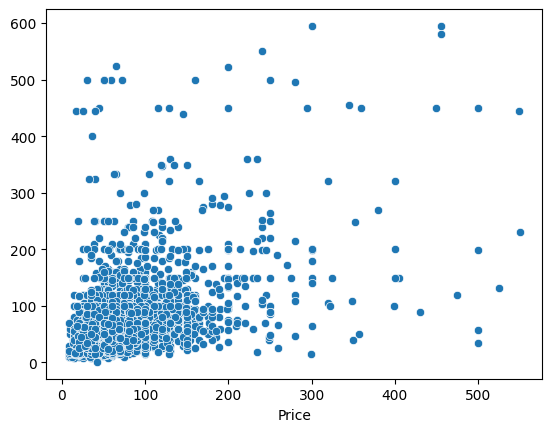

In [298]:
sns.scatterplot(x=y_val, y=y_val_pred2)

##Random Forest

In [299]:
RFRModel = RandomForestRegressor(random_state=1)
RFRModel.fit(X_train, y_train)
# Make predictions on the validation set
y_val_pred3 = RFRModel.predict(X_val)

In [300]:
regressionMetrics(y_val, y_val_pred3)

{'MSE': 1276.8009164455511,
 'RMSE': np.float64(35.73235111835703),
 'MAE': 21.41300787561401,
 'RMSLE': np.float64(0.4316449916357212)}

In [301]:
pred3 = RFRModel.predict(X)
model_dict = {'model': "RandomForest"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val, y_val_pred3)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,1459.184782,38.199277,22.460420,0.486397
1,Decision Tree,2710.282236,52.060371,29.145247,0.580043
2,RandomForest,1276.800916,35.732351,21.413008,0.431645


<Axes: xlabel='Price'>

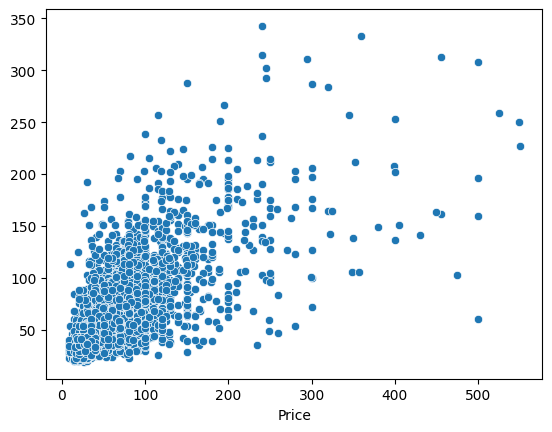

In [302]:
sns.scatterplot(x=y_val, y=y_val_pred3)

##Adaptive Boosting (ADABoost)

In [303]:
mod4 = AdaBoostRegressor(random_state=1)
mod4.fit(X_train, y_train)

AdaBoostRegressor(random_state=1)

In [304]:
# Make predictions on the validation set
y_val_pred4 = mod4.predict(X_val)

In [305]:
model_dict = {'model': "ADABoost"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val, y_val_pred4)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,1459.184782,38.199277,22.460420,0.486397
1,Decision Tree,2710.282236,52.060371,29.145247,0.580043
2,RandomForest,1276.800916,35.732351,21.413008,0.431645
3,ADABoost,2415.924108,49.152051,35.715000,0.666885


<Axes: xlabel='Price'>

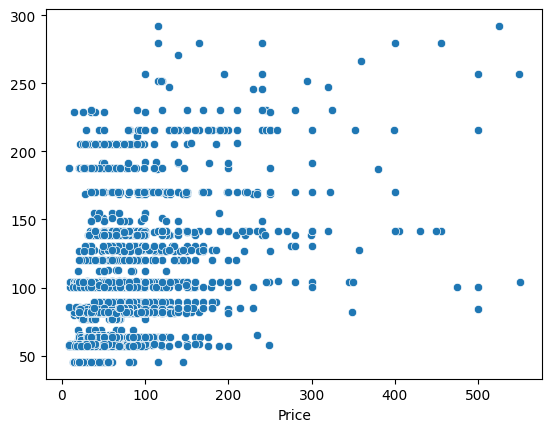

In [306]:
sns.scatterplot(x=y_val, y=y_val_pred4)

##Gradient Boosting Machine (GBM)

In [307]:
mod5 = GradientBoostingRegressor(random_state=1)
mod5.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

In [308]:
# Make predictions on the validation set
y_val_pred5 = mod5.predict(X_val)

In [309]:
model_dict = {'model': "GBM"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val, y_val_pred5)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,1459.184782,38.199277,22.460420,0.486397
1,Decision Tree,2710.282236,52.060371,29.145247,0.580043
2,RandomForest,1276.800916,35.732351,21.413008,0.431645
3,ADABoost,2415.924108,49.152051,35.715000,0.666885
4,GBM,1213.968556,34.842052,20.624492,0.420399


<Axes: xlabel='Price'>

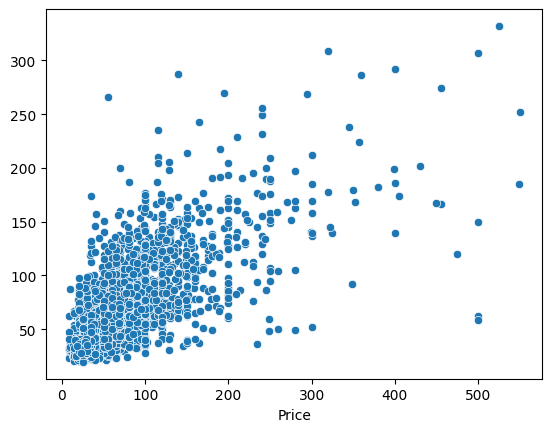

In [310]:
sns.scatterplot(x=y_val, y=y_val_pred5)

##Support Vector Machine (SVM)

In [311]:
mod6 = SVR()
mod6.fit(X_train, y_train)
# Make predictions on the validation set
y_val_pred6 = mod6.predict(X_val)

In [312]:
model_dict = {'model': "SVM"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val,y_val_pred6)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,1459.184782,38.199277,22.460420,0.486397
1,Decision Tree,2710.282236,52.060371,29.145247,0.580043
2,RandomForest,1276.800916,35.732351,21.413008,0.431645
3,ADABoost,2415.924108,49.152051,35.715000,0.666885
4,GBM,1213.968556,34.842052,20.624492,0.420399
5,SVM,2480.768845,49.807317,27.956536,0.566526


<Axes: xlabel='Price'>

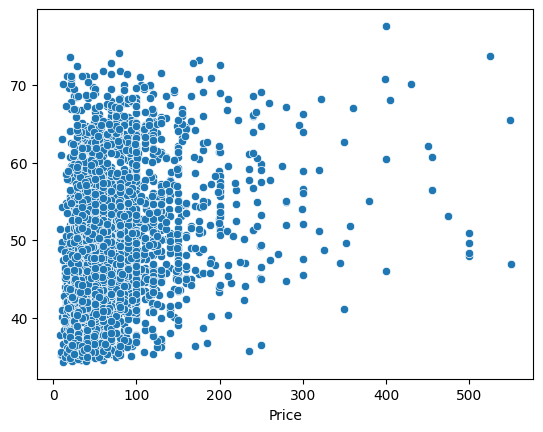

In [313]:
sns.scatterplot(x=y_val, y=y_val_pred6)

##XGBoost Regressor

In [314]:
mod7= xgb.XGBRegressor()
mod7.fit(X_train, y_train)
# Make predictions on the validation set
y_val_pred7 = mod7.predict(X_val)

In [315]:
model_dict = {'model': "XGB"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_val,y_val_pred7)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list

,model,MSE,RMSE,MAE,RMSLE
0,Linear Regression,1459.184782,38.199277,22.460420,0.486397
1,Decision Tree,2710.282236,52.060371,29.145247,0.580043
2,RandomForest,1276.800916,35.732351,21.413008,0.431645
3,ADABoost,2415.924108,49.152051,35.715000,0.666885
4,GBM,1213.968556,34.842052,20.624492,0.420399
5,SVM,2480.768845,49.807317,27.956536,0.566526
6,XGB,1152.483541,33.948248,20.660896,0.425932


<Axes: xlabel='Price'>

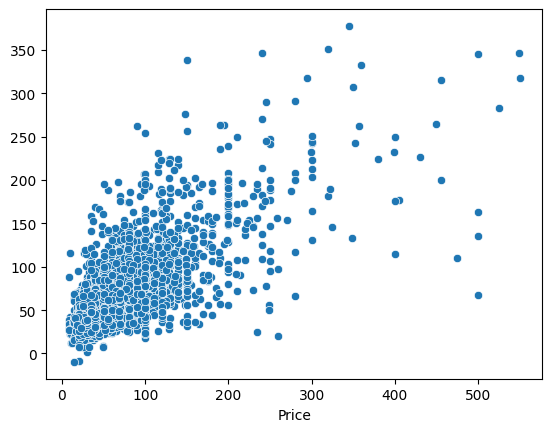

In [316]:
sns.scatterplot(x=y_val, y=y_val_pred7)

## Model Selection

Metrics:<br><b>MSE</b> - Mean Squared Error<br><b>RMSE</b> Root Mean Squared Error<br><b>MAE </b>Mean Absolute Error Calculates the average of the absolute differences between predicted and actual values.<br>
<b>RMSLE</b> Root Mean Squared Logarithmic Error

In [317]:
models_list.sort_values('MAE')

,model,MSE,RMSE,MAE,RMSLE
4,GBM,1213.968556,34.842052,20.624492,0.420399
6,XGB,1152.483541,33.948248,20.660896,0.425932
2,RandomForest,1276.800916,35.732351,21.413008,0.431645
0,Linear Regression,1459.184782,38.199277,22.460420,0.486397
5,SVM,2480.768845,49.807317,27.956536,0.566526
1,Decision Tree,2710.282236,52.060371,29.145247,0.580043
3,ADABoost,2415.924108,49.152051,35.715000,0.666885


# Hyperparameters and Finetuning

In [318]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Random Search: we decide which parameters and how (randomly)

In [319]:
# Reduced number of options for each hyperparameter
n_estimators = [100, 200, 300]  # Fewer values for the number of trees
max_features = ['auto','sqrt']  #  # Number of features to consider at each split
max_depth = [10, 20, 30, 40, None]  # Fewer values for max depth
min_samples_split = [2, 5, 10]  # Keep essential options only
min_samples_leaf = [1, 2, 4]  # Reduced options for leaf samples
bootstrap = [True, False]  # Keep as is

# Create a lighter random grid
lighter_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

print(lighter_grid)

# Reduced number of iterations and cross-validation folds
rf_random = RandomizedSearchCV(estimator=RFRModel, param_distributions=lighter_grid, n_iter=25, cv=3,
                               verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

{'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [323]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=5,
                      n_estimators=300, random_state=1)

In [320]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mae = 100 * np.mean(errors)
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}'.format(np.mean(errors)))
    return mae

#Running base Model

In [324]:
base_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Mean Absolute Error: 21.3321


In [325]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Mean Absolute Error: 20.3223


In [327]:
print('Improvement of {:0.2f}%. when running on RandomForestRegressor model '.format( 100 * (base_accuracy - random_accuracy) / base_accuracy))

Improvement of 4.73%. when running on RandomForestRegressor model 


#Model Evaluation

##Performance Metrics with the fine tuned Model

In [328]:
# make predictions on the validation set
y_val_pred_RFR_best_random = best_random.predict(X_val)

In [330]:
model_dict = {"model":"RandomForest_Tuned"}
model_dict.update(regressionMetrics(y_val, y_val_pred_RFR_best_random))
new_row = pd.DataFrame([model_dict])
models_list = pd.concat([models_list, new_row], ignore_index=True)
models_list.sort_values('MAE')

,model,MSE,RMSE,MAE,RMSLE
7,RandomForest_Tuned,1187.565166,34.461067,20.389644,0.414862
4,GBM,1213.968556,34.842052,20.624492,0.420399
6,XGB,1152.483541,33.948248,20.660896,0.425932
2,RandomForest,1276.800916,35.732351,21.413008,0.431645
0,Linear Regression,1459.184782,38.199277,22.460420,0.486397
5,SVM,2480.768845,49.807317,27.956536,0.566526
1,Decision Tree,2710.282236,52.060371,29.145247,0.580043
3,ADABoost,2415.924108,49.152051,35.715000,0.666885
